# **Checking for GPU**

In [1]:
!nvidia-smi

Wed May 17 22:04:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


**Installing dependencies**

In [3]:
!pip install transformers klib sentencepiece
# klib -> A Python library for importing, cleaning, analyzing and preprocessing data.
# transformers -> Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.
# sentencepiece -> MT5Tokenizer requires the SentencePiece library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.3 MB/s eta 0:00:00


In [4]:
# imports

from transformers import (
    MT5Config, 
    TFMT5ForConditionalGeneration,
    MT5Model, 
    MT5Tokenizer, 
    AdamW,
    AutoConfig
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
import matplotlib.pyplot as plt
import numpy as np
import os


In [5]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/685 Project/NLP Ethos - ethos.csv')
print('Shape of the Dataframe: ', df.shape)
display(df.head())
display(df.columns)

english_df = df[df['Language'] == 'English']
hindi_df = df[df['Language'] == 'Hindi']


Shape of the Dataframe:  (1022, 4)


,Language,Text,Label,Translation
0,Hindi,You should know women's sports are a joke,1,आपको पता होना चाहिए कि महिला खेल एक मजाक होता है।
1,Hindi,You look like Sloth with deeper Down’s syndrome,1,आप गहरे डाउन सिंड्रोम वाले स्लॉथ की तरह दिखते हैं
2,Hindi,You look like Russian and speak like Indian. B...,1,आप रूसी की तरह दिखते हैं और भारतीय की तरह बोलत...
3,Hindi,"Women deserve to be abused, I guess.",1,मुझे लगता है कि महिलाएं दुर्व्यवहार के लायक हैं।
4,Hindi,Women are made for making babies and cooking d...,1,औरतें बच्चे पैदा करने और रात का खाना बनाने के ...


Index(['Language', 'Text', 'Label', 'Translation'], dtype='object')

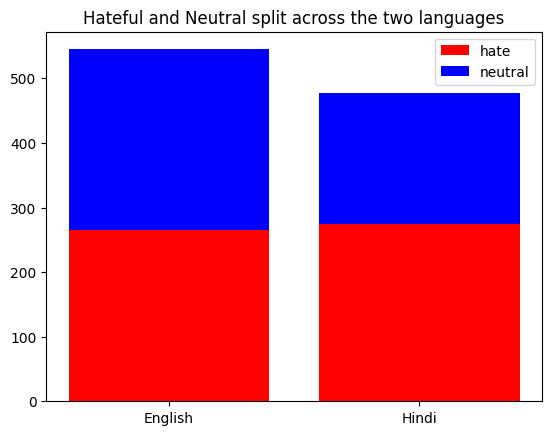

In [7]:
# EDA

import matplotlib.pyplot as plt
import numpy as np
 

lang = ['English', 'Hindi']
hate = np.array([english_df[english_df['Label']==1].shape[0], hindi_df[hindi_df['Label']==1].shape[0]])
neutral = np.array([english_df[english_df['Label']==0].shape[0], hindi_df[hindi_df['Label']==0].shape[0]])
 

plt.bar(lang, hate, color='r')
plt.bar(lang, neutral, bottom=hate, color='b')

plt.legend(["hate", "neutral"])
plt.title("Hateful and Neutral split across the two languages")
plt.show()

**Downloading Tokenizer**

In [8]:
model_path = '/content/gdrive/MyDrive/685 Project/fine-tuned_mt5/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

In [9]:
# Loading tokenizer and model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MT5Tokenizer

tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [10]:
len(tokenizer.vocab)

250100

**Tokenizing**

In [11]:
# Adding the prefix  as a special token
LANG_TOKEN_MAPPING = {
    'detect hate speech': '<detect_hs>'
}
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)

print(tokenizer.all_special_tokens)

['</s>', '<unk>', '<pad>', '<detect_hs>']


In [12]:
MAX_LEN = 512 # Use the maximum input length for MT5 or ByT5
MAX_LABEL_LEN = 3
TASK_PREFIX = "<detect_hs> "

from torch.utils.data import random_split

hindi_train_df, val_df = train_test_split(hindi_df, test_size=0.2, random_state=42, shuffle=True)

train_df = pd.concat([english_df, hindi_train_df], ignore_index=True)

# Placeholders input
train_input_ids, train_input_masks, val_input_ids, val_input_masks = [], [], [], []

# Placeholders output
train_output_ids, train_output_masks, val_output_ids, val_output_masks = [], [], [], []


for index, row in train_df.iterrows():
  sentence = row.Translation
  label = row.Label

  input_encoded = tokenizer.encode_plus(
      TASK_PREFIX + sentence + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  label_ = "hate" if label else "neutral"
  output_encoded = tokenizer.encode_plus(
      label_ + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LABEL_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  labels = output_encoded['input_ids']
  labels[labels == tokenizer.pad_token_id] = -100

  train_input_ids.append(input_encoded['input_ids'])
  train_input_masks.append(input_encoded['attention_mask'])
  train_output_ids.append(labels)
  train_output_masks.append(output_encoded['attention_mask'])

# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_input_masks = torch.cat(train_input_masks, dim=0)
train_output_ids = torch.cat(train_output_ids, dim=0)
train_output_masks = torch.cat(train_output_masks, dim=0)

for index, row in val_df.iterrows():
  sentence = row.Translation
  label = row.Label

  input_encoded = tokenizer.encode_plus(
      TASK_PREFIX + sentence + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  label_ = "hate" if label else "neutral"
  output_encoded = tokenizer.encode_plus(
      label_ + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LABEL_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  labels = output_encoded['input_ids']
  labels[labels == tokenizer.pad_token_id] = -100

  val_input_ids.append(input_encoded['input_ids'])
  val_input_masks.append(input_encoded['attention_mask'])
  val_output_ids.append(labels)
  val_output_masks.append(output_encoded['attention_mask'])

val_input_ids = torch.cat(val_input_ids, dim=0)
val_input_masks = torch.cat(val_input_masks, dim=0)
val_output_ids = torch.cat(val_output_ids, dim=0)
val_output_masks = torch.cat(val_output_masks, dim=0)

from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_input_ids, train_output_ids, train_input_masks, train_output_masks)
val_dataset = TensorDataset(val_input_ids, val_output_ids, val_input_masks, val_output_masks)

**DataLoaders**

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 # considering the computing resources, training time, training data size

# Create the DataLoaders for our training and validation sets.

# RandomSampler for training
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# SequentialSampler for validation
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

**Download Model**

In [14]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

model.cuda() # Tell PyTorch to run this model on the GPU

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

**Optimizer**

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

**Fine Tuning**

In [16]:
from transformers import get_linear_schedule_with_warmup

epochs = 14

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

In [17]:
import random
import numpy as np
from time import time, sleep

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_output_ids = batch[1].to(device)
        b_input_masks = batch[2].to(device)
        b_output_masks = batch[3].to(device)
        
        model.zero_grad()

        outputs = model(input_ids=b_input_ids, 
                        labels=b_output_ids, 
                        attention_mask=b_input_masks, 
                        decoder_attention_mask=b_output_masks)

        loss = outputs.loss
        logits = outputs.logits
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    print(avg_train_loss)



======== Epoch 1 / 14 ========
Training...
12.65129848903623

======== Epoch 2 / 14 ========
Training...
0.9758334086228418

======== Epoch 3 / 14 ========
Training...
0.46586335830165654

======== Epoch 4 / 14 ========
Training...
0.41968161045124047

======== Epoch 5 / 14 ========
Training...
0.3887179769928856

======== Epoch 6 / 14 ========
Training...
0.30525989654666646

======== Epoch 7 / 14 ========
Training...
0.2958549377347889

======== Epoch 8 / 14 ========
Training...
0.27104307239642367

======== Epoch 9 / 14 ========
Training...
0.2685166177689098

======== Epoch 10 / 14 ========
Training...
0.23269639663616043

======== Epoch 11 / 14 ========
Training...
0.23423883662125544

======== Epoch 12 / 14 ========
Training...
0.23452076305781294

======== Epoch 13 / 14 ========
Training...
0.21701193442866748

======== Epoch 14 / 14 ========
Training...
0.1999852152330277


**Save the model**

In [18]:
# save model
torch.save(model.state_dict(), model_path+f"english+hindi.pt")

**Validation**

In [19]:
model.eval() 

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [20]:
# validation
v_match = 0

for step, batch in enumerate(validation_dataloader):
    
    v_input_ids = batch[0].to(device)
    v_output_ids = batch[1].to(device)
    v_input_masks = batch[2].to(device)
    v_output_masks = batch[3].to(device)
  
    v_outputs = model.generate(input_ids=v_input_ids, 
                            attention_mask=v_input_masks,
                            max_length=3)
    
    for v_input_id, true_v_output, pred_v_output in zip(v_input_ids, v_output_ids, v_outputs):
      true_label = tokenizer.decode(true_v_output, skip_special_tokens=True)
      pred_label = tokenizer.decode(pred_v_output, skip_special_tokens=True)
      if pred_label == true_label:
        v_match += 1
      else:
        print()
        print(f"{tokenizer.decode(v_input_id, skip_special_tokens=True)} true={true_label} pred={pred_label}")
      
v_acc = v_match/len(val_dataset)

print(f"\nval acc = {v_acc}\n")


पीरियड को एक प्राकृतिक प्रक्रिया के रूप में बताकर अनुमति देना, उनके लिंग को नीचा दिखाता है। मुझे लगता है कि मैं उससे सहमत हूं, हालांकि वे अन्यथा भी नीचा दिखाए जाते हैं।  true=hate  pred=neutral 

यह बहुत पापी है। यह बाइबिल में कहता है कि तुम बेवकूफ बकवास करते हो। यह कहना बंद करें कि अगर आप गे हैं तो आप स्वर्ग जाएंगे। क्योंकि तुम स्वर्ग नहीं जाओगे। मुझ पर विश्वास करें कि यह मेरी GF द्वारा डेट की जाने वाली लड़कियों की एक कमबख्त पसंद है और मैं उसकी दूसरी bf थी, उसने 12 लड़कियों की तरह डेट किया और वह 100% सीधी है। आप दाईं ओर बदल सकते हैं :)  true=hate  pred=neutral 

आइए इन विचित्र लोगों को हराएं!  true=hate  pred=neutral 

उसने कहा कि वह अपने भगवान से प्यार करने के लिए पागल है। वैसे वह सचमुच पागल है। मैं उसे उसके जीवन से राहत दे सकता हूं।  true=hate  pred=neutral 

ये क्या, बेवकूफ लोग हैं!!!  true=hate  pred=neutral 

अगर गोरे लोग इस धरती से चले गए तो हम सीधे पाषाण युग में चले जाएंगे। मजाक भी नहीं कर रहा  true=neutral  pred=hate 

औरत!!! एक जोड़ी विकसित करें और पुरुषों के साथ प्रतिस्पर्ध

**Testing**

In [26]:
test_df = pd.read_csv("//content/gdrive/MyDrive/685 Project/Friends - hindi - Sheet1.csv")
print('Shape of the Dataframe: ', test_df.shape)
display(test_df.head())

test_input_ids, test_input_masks, test_output_ids, test_output_masks = [], [], [], []

for index, row in test_df.iterrows():
  sentence = row.Translations
  label = row.label

  input_encoded = tokenizer.encode_plus(
      TASK_PREFIX + sentence + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  label_ = "hate" if label else "neutral"
  output_encoded = tokenizer.encode_plus(
      label_ + ' </s>',
      add_special_tokens = True,
      max_length = MAX_LABEL_LEN,
      truncation = True,
      padding = 'max_length',
      return_tensors = 'pt'
  )

  labels = output_encoded['input_ids']
  labels[labels == tokenizer.pad_token_id] = -100

  test_input_ids.append(input_encoded['input_ids'])
  test_input_masks.append(input_encoded['attention_mask'])
  test_output_ids.append(labels)
  test_output_masks.append(output_encoded['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_input_masks = torch.cat(test_input_masks, dim=0)
test_output_ids = torch.cat(test_output_ids, dim=0)
test_output_masks = torch.cat(test_output_masks, dim=0)

test_dataset = TensorDataset(test_input_ids, test_output_ids, test_input_masks, test_output_masks)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = 1
        )


t_match = 0

for step, batch in enumerate(test_dataloader):
    
    t_input_ids = batch[0].to(device)
    t_output_ids = batch[1].to(device)
    t_input_masks = batch[2].to(device)
    t_output_masks = batch[3].to(device)
  
    t_outputs = model.generate(input_ids=t_input_ids, 
                            attention_mask=t_input_masks,
                            max_length=3)
    
    for t_input_id, true_t_output, pred_t_output in zip(t_input_ids, t_output_ids, t_outputs):
      true_label = tokenizer.decode(true_t_output, skip_special_tokens=True)
      pred_label = tokenizer.decode(pred_t_output, skip_special_tokens=True)
      if pred_label == true_label:
        t_match += 1
      else:
        print()
        print(f"{tokenizer.decode(t_input_id, skip_special_tokens=True)} true={true_label} pred={pred_label}")
      
t_acc = t_match/len(test_dataset)

print(f"\ntest acc = {t_acc}\n")

Shape of the Dataframe:  (61, 3)


,Text,label,Translations
0,"Nevermind, my girlfriend’s a lesbian.",1,"कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।"
1,Yuck! Are you gay?,1,छी! क्या आप समलैंगिक हैं?
2,"Hey, Joey. Are men ever nice to strange women ...",1,"हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्..."
3,"Wanted:Female Roommate. Non-smoker, non-ugly.",1,"चाहिए: महिला रूममेट. धूम्रपान नहीं, बिना बदसूर..."
4,You kissed a guy! Oh my god. Be a man!,1,तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदम...



कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।  true=hate  pred=neutral 

हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्रति बिना किसी कारण के अच्छे व्यवहार करते हैं?  true=hate  pred=neutral 

तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदमी बनो!  true=hate  pred=neutral 

जैसा चाहो, यार। तुमने एक आदमी को चुम्मा दिया! मेरे लिए तुम मौजूद नहीं हो।  true=hate  pred=neutral 

मुझे एक योजना चाहिए थी, अपने पुरुष से पार करने के लिए। और पुरुष का विपरीत क्या होता है? जाम।  true=hate  pred=neutral 

चैंडलर, तुम घिनौने हो। कौन शार्क पॉर्न देखता है!  true=hate  pred=neutral 

असली दुनिया में आपका स्वागत है! यह बहुत बेकार है।  true=hate  pred=neutral 

मैं एक औरतों के दीवाने नहीं हूँ। मैं किसी एक औरत का नाम भी उठा नहीं सकता, जिससे मैंने सच्चा कारण बताकर ब्रेकअप किया हो।  true=hate  pred=neutral 

जैसा कि आप सभी जानते हैं, मैं एक शांतिवादी हूँ जिसका अर्थ है कि मुझे युद्ध की कोई इच्छा नहीं है - किसी भी तरीके से नहीं। लेकिन जब क्रांति आएगी, तो मुझे आप सभी को नष्ट करना होगा।  true=hate  pred=neutral 

अरे,